# Installing and Importing packages for anallysis

In [1]:
#uncomment the lines to install particular packages in your notebook

#!conda install numpy --yes
#!conda install scipy --yes
#!conda install scikit-learn --yes
#!conda install matplotlib --yes
#!conda install seaborn --yes

In [18]:
#Misc
import scipy.io as sio
import os #to access files from the directories
import math
import time #to check total time took for running the script or function

#Visualization
import matplotlib.pyplot as plt

#Analysis
import pandas as pd
import numpy as np
from sklearn import svm
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import permutation_test_score
from sklearn.model_selection import StratifiedKFold
from sklearn.utils import shuffle
from sklearn.naive_bayes import GaussianNB
from sklearn import tree




## Data extraction
Reading only Faces mat files which doesnt end with 389.mat as I still do not know what it represents. Extracting means for each sample along with its label for all the brain areas. Not sure how to store the data, check with pandas **most probably pandas dataframe**

In [2]:
dataFolder =  "../Data/"
columns = ["means","label"]
#df = pd.DataFrame({'A':1,'B':2}, index = None)
data_list = []
for matFile in os.listdir(dataFolder):
    if matFile.startswith("Faces") and not matFile.endswith("389.mat"):
        data = sio.loadmat(dataFolder + matFile)
        for i in range (len(data["means"])):
        #data_list.append(list(zip(data["means"],data["label"][0]))) # Check this how to do it
            d = data["means"][i],data["label"][0][i]
            data_list.append(d)
        print(len(data["means"]))
df = pd.DataFrame(data_list, columns = columns)
RoiNames = (data["RoiName"][:,0])
colRoi = []
for roi in RoiNames:
    colRoi.append(roi[0])
df[colRoi] = pd.DataFrame(df.means.values.tolist(), index = df.index)
df.drop(['means'], axis=1, inplace=True)



NameError: name 'os' is not defined

In [21]:
df.head()

,label,Precentral_L,Precentral_R,Frontal_Sup_L,Frontal_Sup_R,Frontal_Sup_Orb_L,Frontal_Sup_Orb_R,Frontal_Mid_L,Frontal_Mid_R,Frontal_Mid_Orb_L,...,Cerebelum_10_L,Cerebelum_10_R,Vermis_1_2,Vermis_3,Vermis_4_5,Vermis_6,Vermis_7,Vermis_8,Vermis_9,Vermis_10
0,1,-0.261413,-0.614965,-0.184144,-0.300383,0.553060,1.017965,-0.500928,-0.467032,-0.381950,...,-0.408351,-1.147118,-2.567101,-2.049433,-1.754564,-0.606973,-0.860277,-1.658649,0.168726,1.006011
1,1,-1.772200,-1.107698,-2.027145,-1.532820,-1.816469,-1.896132,-1.922224,-1.868986,-1.361453,...,-1.191585,-0.902862,-0.724082,-2.444238,-2.153109,-2.263649,-1.709332,-1.529465,0.164342,1.231301
2,1,0.254926,0.657548,-0.007574,0.143625,0.918835,0.996188,0.278585,0.280610,0.229048,...,0.883772,-0.184331,1.751579,-0.775282,0.687507,0.872222,0.658151,1.525205,-0.809088,-1.525038
3,1,-0.081679,-0.548619,-0.022460,-0.195238,-0.960115,-0.061683,-0.068000,-0.336466,-1.094314,...,-0.327843,-0.593949,-1.237898,-0.295273,-0.340851,-1.360729,-0.839502,-1.853460,-1.124791,-0.546470
4,1,0.810675,0.401977,0.553865,1.052446,0.947727,0.089213,0.934677,0.635166,1.384241,...,0.522811,0.434035,1.737797,-2.831582,-0.637470,0.195835,1.128861,1.374655,0.746394,-2.622827


## Training and Testing Data
Shuffle the rows to avoid overfitting. Divide the the data into training and testing dataset (80% : 20%). Use training dataset for cross validation (5 or 10 folds)

***Temporary fix for NaN is by replacing it by 0***

In [22]:
np.all(np.isfinite(df)) # to check if there is any infinite number
np.any(np.isnan(df)) #to check if there is any nan

np.where(np.asanyarray(np.isnan(df))) #to find the index of nan
df = df.fillna(0) #replace nan with 0

df = shuffle(df)

split_index = math.floor(0.8 * len(df))
train = df[:split_index]
test = df[split_index:]

# SVM model fitting
Using SVM from sklearn, fit the model and the cross validation accuracy without feature engineering.

In [23]:
#Training or model fitting
features = train.loc[:, train.columns != "label"].values
type_label = np.asarray(train.label)
model = svm.SVC(kernel = 'rbf', C = 4, gamma = 2**-5)
model.fit(features,type_label)
scores = cross_val_score(model, features, type_label, cv=5)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
#print(features.shape)

Accuracy: 0.49 (+/- 0.03)


In [24]:
#Testing
test_data = test.loc[:,test.columns != "label"].values
test_actual_results = np.asarray(test.label).astype(float)
test_prediction = model.predict(test_data)
total_test_samples = test_data.shape[0]
total_correct_predictions = np.count_nonzero(test_actual_results == test_prediction)
print("Test Accuracy is {}.".format(total_correct_predictions / total_test_samples))

Test Accuracy is 0.4594594594594595.


## Permutation Test
For checking the significance of SVM classifier, non-parameteric permutation test is applied with 100 permuations. The below code will do permutation on the labels for 100 times. Scoring is **accuracy** and cv is **StratifiedKFold**.  

# SVM

In [25]:
start = time.time()
model = svm.SVC(kernel = 'rbf', C = 4, gamma = 2**-5)
cv = StratifiedKFold(5)
score, permutation_scores, pvalue = permutation_test_score(
    model, features, type_label, scoring="accuracy", cv = cv, n_permutations = 100, n_jobs = 1)
print("Classification Score : %s \np-value : %s" %(score,pvalue))
print("It took %s seconds to do the permutation test" %(time.time()-start))

Classification Score : 0.48555838772174786 
p-value : 0.009900990099009901
It took 89.47065210342407 seconds to do the permutation test


(0.0, 17.85)

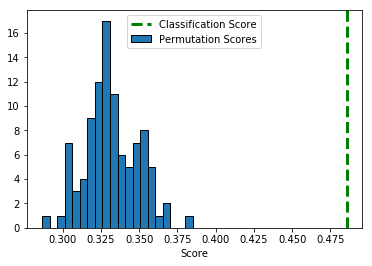

In [26]:
plt.hist(permutation_scores, 20 , edgecolor = "black" , label = "Permutation Scores")
ylim = plt.ylim()
plt.plot(2 * [score], ylim, "--g", linewidth = 3, label = "Classification Score" )
plt.xlabel("Score")
plt.legend()
plt.ylim(ylim)

In [28]:
print(type(permutation_scores))

<class 'numpy.ndarray'>


# Naive_Bayes

In [29]:
model_naive = GaussianNB()
score, permutation_scores, pvalue = permutation_test_score(
    model_naive, features, type_label, scoring="accuracy", cv = cv, n_permutations = 100, n_jobs = 1)
print("Classification Score : %s \np-value : %s" %(score,pvalue))
print("It took %s seconds to do the permutation test" %(time.time()-start))


Classification Score : 0.37257412338142604 
p-value : 0.009900990099009901
It took 91.253347158432 seconds to do the permutation test


(0.0, 12.6)

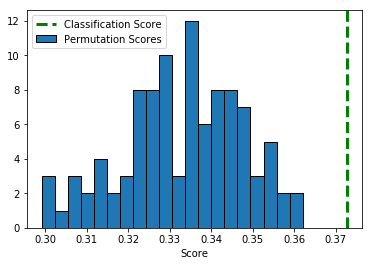

In [30]:
plt.hist(permutation_scores, 20 , edgecolor = "black" , label = "Permutation Scores")
ylim = plt.ylim()
plt.plot(2 * [score], ylim, "--g", linewidth = 3, label = "Classification Score" )
plt.xlabel("Score")  
plt.legend()
plt.ylim(ylim)

# Decision Tree

In [31]:
model_tree = tree.DecisionTreeClassifier()
score, permutation_scores, pvalue = permutation_test_score(
    model_tree, features, type_label, scoring="accuracy", cv = cv, n_permutations = 100, n_jobs = 1)
print("Classification Score : %s \np-value : %s" %(score,pvalue))
print("It took %s seconds to do the permutation test" %(time.time()-start))


Classification Score : 0.4257192709968143 
p-value : 0.009900990099009901
It took 132.70760917663574 seconds to do the permutation test


(0.0, 15.75)

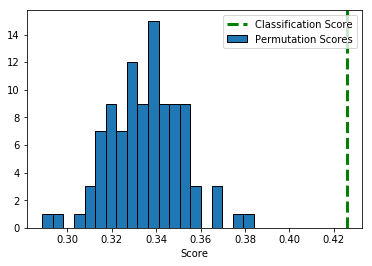

In [32]:
plt.hist(permutation_scores, 20 , edgecolor = "black" , label = "Permutation Scores")
ylim = plt.ylim()
plt.plot(2 * [score], ylim, "--g", linewidth = 3, label = "Classification Score" )
plt.xlabel("Score")
plt.legend()
plt.ylim(ylim)